## Demonstrating the difficulty of performing a sentiment analysis for a SEA language at the same richness level as in English

### Sentiment analysis

We pick Indonesian to represent a SEA language in this demo. Except for Malay, Thai and Vietnamese, which are more or less in similar states as Indonesian, the limitations demonstrated here currently are more severely felt for the other major SEA languages, i.e. Filipino Khmer, Lao and Burmese. 

In [1]:
import numpy as np
import pandas as pd

import fasttext

We are using a sentence level sentiment analysis data from the IndoNLU repository (https://github.com/indobenchmark/indonlu/tree/master/dataset/smsa_doc-sentiment-prosa).

There are 3 sentiment classes: positive, negative and neutral.

In [2]:
smsa_train = pd.read_csv("Datasets/SMSA/train_preprocess.tsv", sep="\t", header=None)
smsa_test = pd.read_csv("Datasets/SMSA/valid_preprocess.tsv", sep="\t", header=None)

smsa_train.columns = ["text", "label"]
smsa_test.columns = ["text", "label"]

display(smsa_train.head(5))

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


Unlike in high resource languages like English and Chinese, state-of-the-art transformers-based models are not readily available for most of SEA languages. We often need to resort to classical methods to perform NLP analysis, like relying on TF-IDF features. Luckily for us, embedding representations for SEA languages, i.e. something that are more advanced than TF-IDF, are available to use for sentiment analysis. One can download these embeddings from the library `fasttext` (https://fasttext.cc/docs/en/crawl-vectors.html).  

**Note:** For Indonesian, there are actually some BERT-based models that can be used for sentiment analysis. But we cannot assume that other SEA languages are in the same state. Therefore, we stick to a more realistic resource like `fasttext`, as we use Indonesian only to represent SEA language in general. Despite the relatively more advanced state of Indonesian NLP, we shall see soon in this demo that the ease of doing NLP in it is still quite far behind English. 

The pretrained Indonesian `fasttext` embedding can be downloaded from https://fasttext.cc/docs/en/crawl-vectors.html, but its size is in GB.

Feel free to just watch this demo during the workshop. In your own time, after the session, you can download the fasttext embedding to do the full hands-on yourself.

Do ignore the warning message when loading the embedding.

In [3]:
ft = fasttext.load_model("Resources/cc.id.300.bin")

When using `fasttext`, one can get the vector representation of a paragraph or a sentence by calling the function `get_sentence_vector`. We use the `apply` function from `pandas` to convert all the paragraphs in the train and test sets into their respective embedding vector representations. 

In [4]:
smsa_train_df = pd.DataFrame.from_records(smsa_train.apply(lambda x: ft.get_sentence_vector(x["text"]), axis=1))
smsa_test_df = pd.DataFrame.from_records(smsa_test.apply(lambda x: ft.get_sentence_vector(x["text"]), axis=1))

In [5]:
display(smsa_train_df.head(3))

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.019443,-0.019986,0.015880,0.089203,-0.027489,-0.080016,-0.002453,0.000192,-0.008916,-0.077531,...,0.008524,-0.009452,-0.010451,0.005987,0.028860,0.001511,-0.006524,-0.025130,-0.005041,0.078958
1,0.000713,-0.002286,0.022383,0.101323,-0.034927,-0.111125,-0.004469,-0.000014,0.007321,-0.122564,...,0.010168,0.009697,-0.009801,0.009453,0.016019,-0.030460,0.018415,-0.075163,-0.042496,0.103455
2,0.023267,-0.024933,-0.001866,0.071155,-0.014397,-0.059937,-0.009548,-0.003358,-0.003229,-0.062060,...,0.012276,-0.007193,-0.014125,0.013846,0.029084,0.030599,0.004075,0.019398,-0.000516,0.037295


Now that we have the vector representation of the text dataset, we can perform a simple binary classification for sentiment analysis. We use `RandomForestClassifier` from `scikit-learn` in this demo. We can as well replace it with any other binary clasifier of out own choosing.   

In [6]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=0)

model.fit(smsa_train_df, smsa_train["label"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

After training, we can do prediction on the test set

In [7]:
pred_sentiment = model.predict(smsa_test_df)

Get the accuracy and confusion matrix

In [8]:
from sklearn.metrics import classification_report

print(classification_report(pred_sentiment, smsa_test["label"]))

              precision    recall  f1-score   support

    negative       0.84      0.77      0.80       431
     neutral       0.67      0.85      0.75       104
    positive       0.89      0.91      0.90       725

    accuracy                           0.85      1260
   macro avg       0.80      0.84      0.82      1260
weighted avg       0.86      0.85      0.85      1260



In [9]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(smsa_test["label"], pred_sentiment)
cm_df = pd.DataFrame(cm, columns=[("True " + i) for i in np.unique(pred_sentiment)], index = [("Predicted " + i) for i in np.unique(pred_sentiment)])

display(cm_df)

,True negative,True neutral,True positive
Predicted negative,330,5,59
Predicted neutral,34,88,9
Predicted positive,67,11,657


Test the model

In [10]:
sample_text = "Makanannya enak dan gurih ya"
prediction = model.predict(ft.get_sentence_vector(sample_text).reshape(1, -1))
print(sample_text, prediction)

sample_text = "Lokasi restoran tersebut sangat strategis"
prediction = model.predict(ft.get_sentence_vector(sample_text).reshape(1, -1))
print(sample_text, prediction)

sample_text = "Lokasi restoran tersebut sangat jauh"
prediction = model.predict(ft.get_sentence_vector(sample_text).reshape(1, -1))
print(sample_text, prediction)

Makanannya enak dan gurih ya ['positive']
Lokasi restoran tersebut sangat strategis ['positive']
Lokasi restoran tersebut sangat jauh ['negative']


### The challenge to do more detailed analyses beyond this point

In the notebook `SentimentAnalysis_EN_2`, we demonstrate that, in English, we can enrich the sentiment analysis, for example by focusing on sentiment that may be associated with PERSON entities. We rely on Named Entity Recognition (NER) primarily, but then potentially going even further in improving the preciseness of the association using Coreference Resolution and Constituency Parsing.  

In Indonesian however, even NER is hard to find, let alone Coreference Resolution and Constituency Parsing. A quick look at `spacy`'s language support (https://spacy.io/usage/models), we can confirm that Indonesian, or any other SEA language, is supported natively there.

Another popular alternative `stanza` (http://stanza.run/), has limited support for Indonesian, Vietnamese and Thai. NER is not one of the supported one (see the screenshot below). Neither is coreference resolution or constituency parsing.

![Stanza's limited support](Images/Stanza.png)

Given this limitation, one possible approach available today is to rely on Multilingual model to do NER in Indonesian or any other SEA language. Please refer to the notebook `Multilingual_NER` for a demonstration.

### Eniriching Indonesian sentiment analysis by NER using SEA CoreNLP

With SEA CoreNLP, we can perform NER, Constituency Parsing and soon Coreference Resolution natively in Indonesian. 

The following example shows how we perform an Indonesian NER and use the output to filter the sentiment values only on those sentences that mention a PERSON.

In [11]:
from seacorenlp.tagging import NERTagger

tagger = NERTagger.from_pretrained("ner-id-nergrit-xlmr-best")

/home/williamtjhi/anaconda3/envs/aip_ws1/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
2022-01-04 09:39:57 INFO: Loading these models for language: id (Indonesian):
| Processor | Package |
-----------------------
| tokenize  | gsd     |

2022-01-04 09:39:57 INFO: Use device: cpu
2022-01-04 09:39:57 INFO: Loading: tokenize
2022-01-04 09:39:57 INFO: Done loading processors!


Let's first test the Indonesian NER model on a sample Indonesian sentence.

In [12]:
sample_text_id = "Joko Widodo adalah presiden ketujuh Republik Indonesia."
display(pd.DataFrame(tagger.predict(sample_text_id)))

sample_text_id = "Saya berangkat dari Jakarta kemarin dan baru tiba di Amerika hari ini."
display(pd.DataFrame(tagger.predict(sample_text_id)))

,0,1
0,Joko,B-PERSON
1,Widodo,I-PERSON
2,adalah,O
3,presiden,O
4,ketujuh,O
5,Republik,B-PLACE
6,Indonesia,I-PLACE
7,.,O


,0,1
0,Saya,O
1,berangkat,O
2,dari,O
3,Jakarta,B-PLACE
4,kemarin,O
5,dan,O
6,baru,O
7,tiba,O
8,di,O
9,Amerika,B-PLACE


We tag as `True` the sentences in the SMSA test set that contains a reference to any PERSON entity. 

In [13]:
smsa_include_person = []
for i in smsa_test["text"]:
    results = tagger.predict(i)
    smsa_include_person.append("PERSON" in [(i[1] if i[1]=="O" else i[1].split("-")[1]) for i in results])

We show the first few sentences that make references to a PERSON.

In [14]:
sample_sentences_w_person = [(x + " [" + pred_sentiment[i] + "]") for i,x in enumerate(smsa_test["text"]) if smsa_include_person[i]]
for i in sample_sentences_w_person[:5]:
    print(i + "\n")

betapa bejad kader gerindra yang anggota dprd mencabuli anak smp , rakyat harus cerdas partai mana yang harus di tengelamkan di 2019 [negative]

kampiun bistro berada di jalan . kebon kawung , sebelah kanan seberang stasiun kota bandung . harga makanan dan minuman nya sangat terjangkau . ada live musik juga . dan kalau beruntung , anda akan bertemu dengan yuke dewa19 di tempat ini . [positive]

kamar nya sempit tidak ada tempat menyimpan barang malah menambah barang . by the way ini kipas2 mau diletakkan mana . mana uchiwa segede ini pula . [negative]

malah .. !!! tren si tukang fitnah bicara iman , dasar akun sapi yang takut kehilangan kursi cawapres prabowo makanya busukkan nama ahy dan say [negative]

gue bingung sama pemerintahan jokowi . banyak orang yang muji dia padahal dia cuma bisa merusak negara kita saja . aneh [negative]



We show the first few sentences that DO NOT make references to a PERSON.

In [15]:
sample_sentences_wo_person = [(x + " [" + pred_sentiment[i] + "]") for i,x in enumerate(smsa_test["text"]) if smsa_include_person[i]==False]
for i in sample_sentences_wo_person[:5]:
    print(i + "\n")

meski masa kampanye sudah selesai , bukan berati habis pula upaya mengerek tingkat kedipilihan elektabilitas . [negative]

tidak enak [negative]

restoran ini menawarkan makanan sunda . kami memesan ayam goreng , kangkung , sayur asam , ikan gurame goreng , ikan bakar , nasi goreng , karedok , tahu tempe , nasi putih , nasi merah etc minuman yang mereka tawarkan juga cukup variatif . rasa makanan enak dan harga murah . kami 9 dewasa dan 5 anak kecil , hanya menghabiskan 800,000 [positive]

lokasi di alun alun masakan padang ini cukup terkenal dengan kepala ikan kakap gule , biasa saya pesan nasi bungkus padang berisikan rendang , ayam pop dan perkedel . porsi banyak dan mengenyangkan [positive]

saya tadi mampir ke restauran ini , mungkin letak nya strategis , pertama masuk dikasih senyuman manis sama mbak yang ramah , di situ pun saya memesan chiken grill , es thai tea dan super duper ice cream . enak . saya suka . [positive]



Just like what we have done in English, let's look at the sentiment distribution if we consider only those sentences that make any reference to a person. We can contrast it with the sentiment distribution of all the sentences in the test set. 

In this particular dataset, we can see that when there are references to PERSON in sentences, the chance of the sentences being negative is high. Overall, there are actually far more positive sentences than negative ones. 

,negative,neutral,positive
mentioning_a_person,93,45,23
all_reviews,431,104,725


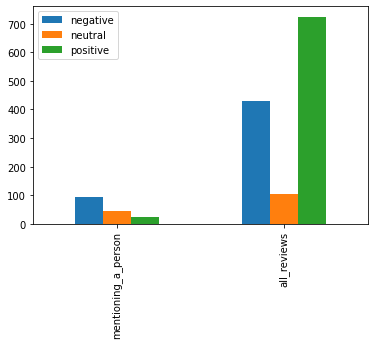

In [16]:
import matplotlib.pyplot as plt

x = pd.Series(pred_sentiment[np.where(smsa_include_person)]).value_counts()
y = pd.Series(pred_sentiment).value_counts()

z = pd.concat([x, y], axis=1)
z.columns =  ["mentioning_a_person", "all_reviews"]
z = z.transpose()

display(z)

z.plot.bar()
plt.show()

### SEA CoreNLP for coreference resolution and constituency parsing

SEA CoreNLP can also be used to perform Indonesian constituency parsing and coreference resolution.

The following shows an example of the output of SEA CoreNLP's constituency parsing in Indonesian on one of the sentences in the test set.

![SEA CoreNLP Constituency](Images/SEACoreNLP_Constituency.png)

The Indonesian coreference resolution model is still in its prototype. We can however preview the output of the model when applied on the SMSA test set in this file: <a href="./SMSA_coreference_result.jsonlines" >SMSA_coreference_result.jsonlines</a>